# (5): Circumstellar Disk Emission Modeling and Analysis

Now that you've experimented with visibility modeling in Part (4), we're going to bring in an outside code package that performs a highly-sophisticated optimization of such models to do the hard work for us.  The package is called '${\tt frankenstein}$'.  If you like, you can read about it in [this article](https://arxiv.org/abs/2005.07709) (this is *not necessary*: it is very complicated!).  You can also read more about the package and, most importantly, how to install it, on an [associated website](https://discsim.github.io/frank/index.html).

Again, to start we load the visibility data:

In [2]:
import os, sys, time           
import numpy as np             
import matplotlib.pyplot as plt
%matplotlib inline                

# disk target name
disk_name = 'SR4'

# load the visibility data
dat = np.load(disk_name+'_continuum.vis.npz')
u, v, vis, wgt = dat['u'], dat['v'], dat['Vis'], dat['Wgt']

Next, we will load the ${\tt frankenstein}$ functions, fix the emission geometry, and then run the visibility model fitting.  What this does is effectively invert the visibility profile in a way that can reconstruct an arbitrary surface brightness distribution.  The code uses a special approach that combines oscillatory behavior drawn from a [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) to match the observations in the Fourier domain.  The details don't really matter here, but the important point is that it really does optimize the solution.  When the emission is genuinely noise, we'll see some oscillatory behavior imprinted on the model, but this usually happens at a level that is negligible.  We can help mitigate that with some parameter choices (I've done that below).  Note that this takes 1-3 minutes!

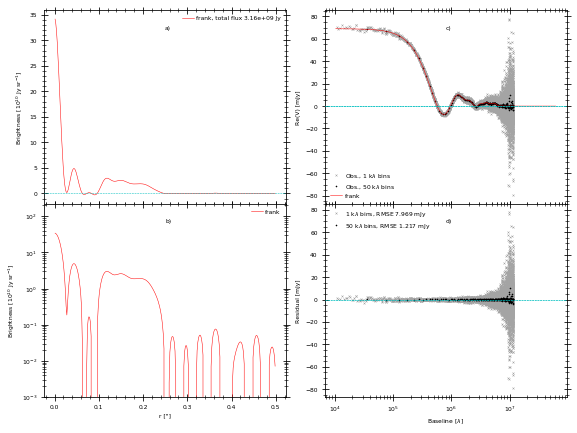

In [6]:
from frank.radial_fitters import FrankFitter
from frank.geometry import FixedGeometry
from frank.make_figs import use_frank_plotting_style, make_quick_fig
from frank.io import save_fit

# set the disk viewing geometry parameters
incl, PA = 22., 26.
offRA, offDEC = -0.060, -0.509
geom = FixedGeometry(incl, PA, dRA=offRA, dDec=offDEC)

# set the frankenstein hyper-parameters
Rmax  = 0.5    # this is ~1.5x the maximum radius where we see emission (in arcseconds)
Ncoll = 300    # this is the # of collocation points used in the model 
alpha = 1.3    # this controls how much noisy data is included in the fit   
wsmth = 0.1    # this controls how much the fit smooths over oscillations

# configure the fitting code setup
FF = FrankFitter(Rmax=Rmax, N=Ncoll, geometry=geom, alpha=alpha, weights_smooth=wsmth)

# fit the visibilities
sol = FF.fit(u, v, vis, wgt)

# save the fit
save_fit(u, v, vis, wgt, sol, prefix='SR4_continuum_frank')

# make a plot to show the outcome
fig, axes = make_quick_fig(u, v, vis, wgt, sol, bin_widths=[1e3, 5e4], force_style=True)

This plot is a bit hard to read, but that's because its just the default settings.  It shows on the left two views of the best-fit radial surface brightness profile, on a linear (top) and logarithmic (bottom) scale.  You can see on the bottom left the oscillations at the noisy parts most clearly.  We expect these not to matter for our purposes.  Note the "extra" Gaussian (or extra gap) in the emission "core" that we would've struggled to include in our model for Part (4)!  The right top panel shows the data visibilities in two binnings: 1 k$\lambda$ in gray, and 50 k$\lambda$ in black, on a log-linear scaling.  The red curve is the best-fit model (i.e., the FT of the brightness profile in the left panels).  The bottom right panel shows the residuals (data $-$ model).

Ok, so we can see from this that the modeling did a great job fitting the visibility data.  Now we want to examine the results in the image-plane.  Unfortunately, without a CfA computer account, I will have to run some setup for you.  I've already done this, so you can grab the data below and then work on the activities.

In [3]:
# first generate the model visibilities and save them: this is what you'd use to make the images
#mvis = sol.predict(u, v, geometry=geom)
#np.savez('SR4_frankmodel.vis.npz', u=u, v=v, Vis=mvis, Wgt=wgt)

# here you'd do the imaging...but we'll skip that

# download the data, model, and residual images (.FITS files)
import urllib.request

# set this to your project directory (or however you like)
wdir = '/Users/sandrews/Desktop/DSHARP_CPDs/'

# download source
dsrc = 'http://www.cfa.harvard.edu/~sandrews/data/'

# if you don't already have the datafiles, download them
files = ['data', 'model', 'resid']
for ifile in files:
    #if not os.path.exists(wdir+'SR4_'+ifile+'.fits'):
    urllib.request.urlretrieve(dsrc+'SR4_'+ifile+'.fits', wdir+'SR4_'+ifile+'.fits')

**Activities:**

- Make a plot with three panels across, showing the images for the data, model, and residuals (with the same stretch, etc., as in Part 1).
- Make a plot showing the residuals image, normalized by the estimated RMS noise level in the image (which is 25 $\mu$Jy/beam).  Use a linear stretch and a diverging color map to show positive and negative residuals clearly.  
- Make a plot with three panels down, showing the polar-projected images for the data, model, and residuals (with the same stretch, etc., as in Part 2).
- For some narrow radial range around the main gap feature, extract, average, and plot the averaged residual profile as a function of the azimuthal angle.

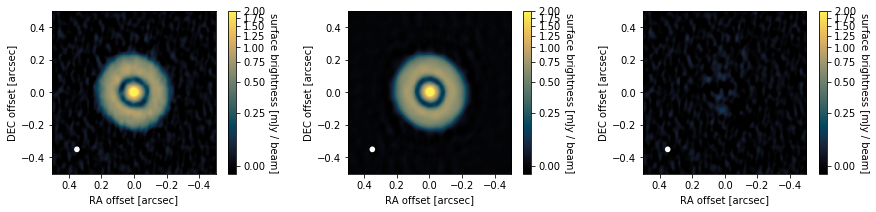

In [4]:
from astropy.io import fits
import cmasher as cmr          # color maps
from astropy.visualization import (AsinhStretch, LogStretch, LinearStretch, ImageNormalize)    # image visualization functions
from matplotlib.patches import Ellipse    # plotting package

# data
data = fits.open('SR4_data.fits')
dimage = np.squeeze(data[0].data)
dheader = data[0].header

# model
data = fits.open('SR4_model.fits')
mimage = np.squeeze(data[0].data)
mheader = data[0].header

# residual
data = fits.open('SR4_resid.fits')
rimage = np.squeeze(data[0].data)
rheader = data[0].header

# coordinates (all the same)
nx, ny = dheader['NAXIS1'], dheader['NAXIS2']
RA = dheader['CRVAL1'] + dheader['CDELT1'] * (np.arange(nx) - (dheader['CRPIX1'] - 1))
DEC = dheader['CRVAL2'] + dheader['CDELT2'] * (np.arange(ny) - (dheader['CRPIX2'] - 1))
RAo, DECo = 3600 * (RA - dheader['CRVAL1']), 3600 * (DEC - dheader['CRVAL2'])
offRA, offDEC = -0.060, -0.509
RAo_shift, DECo_shift = RAo - offRA, DECo - offDEC
dRA, dDEC = np.meshgrid(RAo_shift, DECo_shift)
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())

# get the beam parameters (in **arcseconds** for the FWHM, and **degrees** for the position angle)
beam_maj, beam_min, beam_PA = 3600 * dheader['BMAJ'], 3600 * dheader['BMIN'], dheader['BPA']

# now set the RA and DEC offset ranges you want to show
dRA_lims  = [0.5, -0.5]      # (same reverse ordering to ensure E is to the left)
dDEC_lims = [-0.5, 0.5]

# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2.0    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the image on the specified scale
fig, axs = plt.subplots(ncols=3, figsize=(15,3))

ax = axs[0]
im = ax.imshow(1e3*dimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

ax = axs[1]
im = ax.imshow(1e3*mimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

ax = axs[2]
im = ax.imshow(1e3*rimage, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('surface brightness [mJy / beam]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

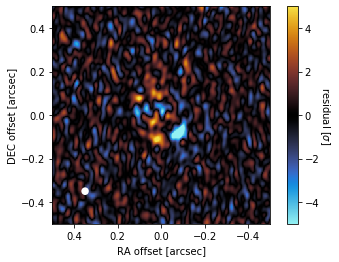

In [5]:
# look at +/- residuals more closely
rms = 25e-3

# now define the color-map, intensity limits, and stretch
cmap = cmr.iceburn
vmin, vmax = -5, 5    # these are in units of RMS
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())

fig, ax = plt.subplots()
im = ax.imshow(1e3*rimage / rms, origin='lower', cmap=cmap, extent=im_bounds, norm=norm, aspect='equal')
ax.set_xlim(dRA_lims)
ax.set_ylim(dDEC_lims)
ax.set_xlabel('RA offset [arcsec]')
ax.set_ylabel('DEC offset [arcsec]')

# add a scalebar
cb = plt.colorbar(im, ax=ax, pad=0.05)
cb.set_label('residual [$\sigma$]', rotation=270, labelpad=13)

# make an ellipse to show the PSF (beam) dimensions, in the lower left corner (its very small!)
beam = Ellipse((dRA_lims[0] + 0.15*np.diff(dRA_lims), dDEC_lims[0] + 0.15*np.diff(dDEC_lims)), 
                beam_maj, beam_min, 90-beam_PA)
beam.set_facecolor('w')
ax.add_artist(beam)

In [7]:
from scipy.interpolate import interp1d

# convert these to radius
incl, PA = 22., 26.
inclr, PAr = np.radians(incl), np.radians(PA)

# deproject and rotate to new coordinate frame
xp = (dRA * np.cos(PAr) - dDEC * np.sin(PAr)) / np.cos(inclr)
yp = (dRA * np.sin(PAr) + dDEC * np.cos(PAr))

# now convert to polar coordinates (r in arcseconds, theta in degrees)
# note that theta starts along the minor axis (theta = 0), and rotates clockwise in the sky plane)
r = np.sqrt(xp**2 + yp**2)
theta = np.degrees(np.arctan2(yp, xp))

# radius and azimuth bin centers (and their widths)
rbins = np.linspace(0.005, 1.5, 300)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees

def razmap(imarray, rbins, tbins):

    # bin widths
    dr = np.abs(rbins[1] - rbins[0])
    dt = np.abs(tbins[1] - tbins[0])
    
    # initialize the (r, az)-map and radial profile
    rtmap = np.empty((len(tbins), len(rbins)))
    SBr, err_SBr = np.empty(len(rbins)), np.empty(len(rbins))

    # loop through the bins to populate the (r, az)-map and radial profile
    for i in range(len(rbins)):
        # identify pixels that correspond to the radial bin (i.e., in this annulus)
        in_annulus = ((r >= (rbins[i] - 0.5 * dr)) & (r < (rbins[i] + 0.5 * dr)))
    
        # accumulate the azimuth values and surface brightness values in this annulus
        az_annulus = theta[in_annulus]
        SB_annulus = imarray[in_annulus]
    
        # average the intensities (and their scatter) in the annulus
        SBr[i], err_SBr[i] = np.average(SB_annulus), np.std(SB_annulus)
    
        # populate the azimuthal bins for the (r, az)-map at this radius
        for j in range(len(tbins)):
            # identify pixels that correspond to the azimuthal bin
            in_wedge = ((az_annulus >= (tbins[j] - 0.5 * dt)) & (az_annulus < (tbins[j] + 0.5 * dt)))
        
            # if there are pixels in that bin, average the corresponding intensities
            if (len(SB_annulus[in_wedge]) > 0):
                rtmap[j,i] = np.average(SB_annulus[in_wedge])
            else:
                rtmap[j,i] = -1e10    # this is a temporary placeholder; it will be fixed in next piece of code
            
    # now "fix" the (r, az)-map where there are too few pixels in certain az bins (inner disk)
    # its ok if this part is a "black box": it is not important / relevant
    for i in range(len(rbins)):
        # extract an azimuthal slice of the (r, az)-map
        az_slice = rtmap[:,i]
    
        # identify if there's missing information in an az bin along that slice:
        # if so, fill it in with linear interpolation along the slice
        if np.any(az_slice < -1e5):
            # extract non-problematic bins in the slice
            x_slice, y_slice = tbins[az_slice >= -1e5], az_slice[az_slice >= -1e5]
        
            # pad the arrays to make sure they span a full circle in azimuth
            x_slice_ext = np.pad(x_slice, 1, mode='wrap')
            x_slice_ext[0] -= 360.
            x_slice_ext[-1] += 360.
            y_slice_ext = np.pad(y_slice, 1, mode='wrap')
        
            # define the interpolation function
            raz_func = interp1d(x_slice_ext, y_slice_ext, bounds_error=True)
        
            # interpolate and replace those bins in the (r, az)-map
            fixed_slice = raz_func(tbins)
            rtmap[:,i] = fixed_slice
        
    class raz_out:
        def __init__(self, razmap, r, az, prof, eprof):
            self.razmap = razmap
            self.r = r
            self.az = az
            self.prof = prof
            self.eprof = eprof
            
    return raz_out(rtmap, rbins, tbins, SBr, err_SBr)

In [8]:
rbins = np.linspace(0.001, 0.5, 200)    # in arcseconds
tbins = np.linspace(-180, 180, 181)     # in degrees

deproj_data = razmap(dimage, rbins, tbins)
deproj_model = razmap(mimage, rbins, tbins)
deproj_resid = razmap(rimage, rbins, tbins)

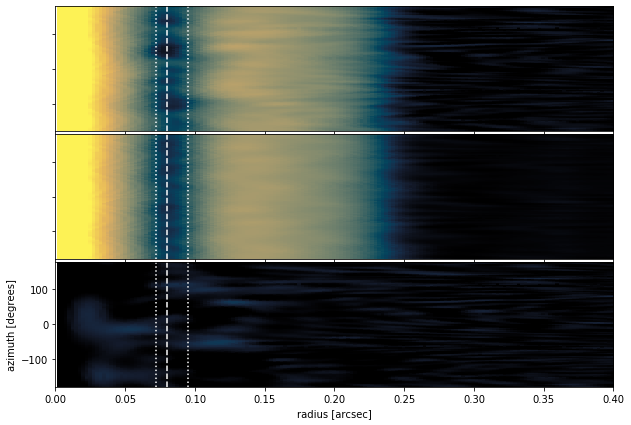

In [9]:
# define the full (r, az)-map boundaries with a list of the min/max (r, az) bins
rtmap_bounds = (rbins.min(), rbins.max(), tbins.min(), tbins.max())

# set the radius and azimuth ranges you want to show
t_lims = [-180, 180]      
r_lims = [0, 0.4]

# now define the color-map, intensity limits, and stretch
cmap = cmr.eclipse
vmin, vmax = -0.03, 2    # these are in mJy/beam units
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

# set up and plot the images on the specified scale
fig, axs = plt.subplots(nrows=3, figsize=(10, 7))

ax = axs[0]
im = ax.imshow(1e3*deproj_data.razmap, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.plot([0.072, 0.072], [-180, 180], ':w')
ax.plot([0.095, 0.095], [-180, 180], ':w')
ax.plot([0.080, 0.080], [-180, 180], '--w')



ax = axs[1]
im = ax.imshow(1e3*deproj_model.razmap, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.plot([0.072, 0.072], [-180, 180], ':w')
ax.plot([0.095, 0.095], [-180, 180], ':w')
ax.plot([0.080, 0.080], [-180, 180], '--w')



ax = axs[2]
im = ax.imshow(1e3*deproj_resid.razmap, origin='lower', cmap=cmap, extent=rtmap_bounds, norm=norm, aspect='auto')
ax.set_xlim(r_lims)
ax.set_ylim(t_lims)
ax.plot([0.072, 0.072], [-180, 180], ':w')
ax.plot([0.095, 0.095], [-180, 180], ':w')
ax.plot([0.080, 0.080], [-180, 180], '--w')


ax.set_ylabel('azimuth [degrees]')
ax.set_xlabel('radius [arcsec]')

fig.subplots_adjust(wspace=0., hspace=0.02)

Text(0, 0.5, 'mean brightness [mJy/beam]')

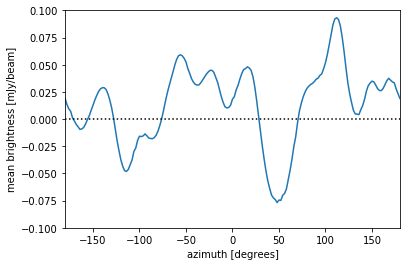

In [31]:
# extract the wedge in the residuals shown in between the dotted white lines above
rrange = (rbins >= 0.072) & (rbins <= 0.095)
wedge = deproj_resid.razmap[:,rrange]

# take the mean of that wedge in the radial direction
az_profile = np.average(wedge, axis=1)

# plot the mean azimuthal profile
fig, ax = plt.subplots()
ax.plot(tbins, 1e3*az_profile)
ax.plot([-180, 180], [0, 0], ':k')
ax.set_xlim([-180, 180])
ax.set_ylim([-0.1, 0.1])
ax.set_xlabel('azimuth [degrees]')
ax.set_ylabel('mean brightness [mJy/beam]')